<a href="https://colab.research.google.com/github/vigu2021/GANs_from_Scratch/blob/main/GAN_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 GAN Self-Implementation on the MNIST Dataset

This notebook demonstrates a self-built Generative Adversarial Network (GAN) using PyTorch to generate handwritten digits similar to those in the MNIST dataset.

The MNIST dataset is a classic benchmark in computer vision, consisting of grayscale images of handwritten digits:
- **Training set**: 60,000 examples
- **Test set**: 10,000 examples

This implementation is based on the foundational GAN paper:
> **Generative Adversarial Nets** by Ian Goodfellow et al.  
> [https://arxiv.org/pdf/1406.2661](https://arxiv.org/pdf/1406.2661)

In this approach, a Generator network learns to produce realistic digits, while a Discriminator network learns to distinguish real digits from fake ones — both networks improve through adversarial training.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=b4acc15fab3394f1756b017e7abc35cd1d384f6dc7148e4e946c5d15d79d805c
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


In [21]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,random_split
import idx2numpy # To read .idx files
import matplotlib.pyplot as plt
import numpy as np

In [22]:
#Define paths to dataset
training_images = "/content/drive/My Drive/MNIST/1/train-images.idx3-ubyte"
training_labels = "/content/drive/My Drive/MNIST/1/train-labels.idx1-ubyte"
test_images =  "/content/drive/My Drive/MNIST/1/t10k-images.idx3-ubyte"
test_labels =  "/content/drive/My Drive/MNIST/1/t10k-labels.idx1-ubyte"


print("Checking file paths...")

print("Training images:", os.path.exists(training_images))
print("Training labels:", os.path.exists(training_labels))
print("Test images:", os.path.exists(test_images))
print("Test labels:", os.path.exists(test_labels))

Checking file paths...
Training images: True
Training labels: True
Test images: True
Test labels: True


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# 1. Define the Dataset

In [24]:
class MNIST_dataset(Dataset):
  def __init__(self,images_path,labels_path,device):
    # Defining routes
    self.images = idx2numpy.convert_from_file(images_path)
    self.labels = idx2numpy.convert_from_file(labels_path)
    self.device = device

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    image = self.images[idx]
    label = self.labels[idx]

    #Convert numpy array -> tensor
    image_tensor = torch.tensor(image).to(dtype = torch.float32,device = self.device)/255.0 #Normalise pixel values 0-1
    image_tensor = image_tensor.unsqueeze(0) #Add extra dimension so each image dimension is (1,28,28)
    label_tensor = torch.tensor(label, dtype=torch.long).to(device = self.device)

    return image_tensor,label_tensor






In [25]:
# Test the dataset
dataset = MNIST_dataset(training_images, training_labels, device)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Grab one batch from the training_loader
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("✅ Correct shape?" , images.shape == (train_loader.batch_size, 1, 28, 28))

    print("Label batch shape:", labels.shape)
    print("✅ Correct shape?", labels.shape == (train_loader.batch_size,))

    print("Image device:", images.device)
    print("✅ On correct device?", str(images.device) == device)

    print("Label device:", labels.device,device)
    print("✅ On correct device?", str(labels.device) == device)

    print("Image dtype:", images.dtype)
    print("✅ Correct dtype?", images.dtype == torch.float32)

    print("Label dtype:", labels.dtype)
    print("✅ Correct dtype?", labels.dtype == torch.int64)

    break  # Only need one batch for testing




Image batch shape: torch.Size([64, 1, 28, 28])
✅ Correct shape? True
Label batch shape: torch.Size([64])
✅ Correct shape? True
Image device: cuda:0
✅ On correct device? False
Label device: cuda:0 cuda
✅ On correct device? False
Image dtype: torch.float32
✅ Correct dtype? True
Label dtype: torch.int64
✅ Correct dtype? True


#2. Creating the Discriminator
Since we're working with image data, we'll use convolutional layers to build our Discriminator. Convolutional layers are more effective at capturing spatial features like edges, textures, and shapes, which helps the model better distinguish between real and generated images.

The Discriminator is a neural network that takes an image (either real or generated) and outputs a probability indicating whether it believes the image is real (1) or fake (0). It acts as a binary classifier and plays the adversary role in a GAN, helping the Generator improve over time by providing feedback.

    Input Image (28×28, Real or Fake)
              ↓
    ┌──────────────────┐
    │  Discriminator   │
    └──────────────────┘
              ↓
    Output: Logit (raw score, not a probability)
         → Use with BCEWithLogitsLoss for stability


In [10]:
#Creating a conv_block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), #Keeps image dimensions
        nn.LeakyReLU(0.2,inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2,inplace = True),
        nn.MaxPool2d(kernel_size=2, stride=2) #Halves the image size
    )
#Overall this block will return image of dimension(out_channels,image_dimension_in/2,image_dimension_in/2)

In [11]:
#Discriminator model
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        conv_block(in_channels=1,out_channels = 8),
        conv_block(in_channels=8,out_channels = 16),
    )
    # Assuming input images are 28x28
        # After 3 conv_blocks with MaxPool2d, image becomes 28 → 14 → 7
        # So final output shape: (batch_size, 16, 7, 7)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=16*7*7,out_features=16),
        nn.ReLU(inplace = True),
        nn.Linear(in_features = 16, out_features=1),
    )

  def forward(self,x):
    x = self.conv_layers(x)
    x = self.classifier(x)
    return x


In [26]:
# Test the discriminator
D = Discriminator().to(device)
for images, labels in train_loader:
  outputs = D(images)
  print("Input shape:", images.shape)       # e.g., (64, 1, 28, 28)
  print("Output shape:", outputs.shape)     # e.g., (64, 1)
  print("Output scores (real probs):", outputs.detach().squeeze().cpu().numpy())
  break



Input shape: torch.Size([64, 1, 28, 28])
Output shape: torch.Size([64, 1])
Output scores (real probs): [0.07430273 0.07198452 0.07178852 0.07442532 0.07350311 0.0705783
 0.0723734  0.07497174 0.07579977 0.07519232 0.07598767 0.07422604
 0.07596829 0.0741927  0.0742624  0.07558832 0.07433886 0.07415663
 0.07317255 0.07538856 0.07489523 0.07197055 0.07489637 0.07720739
 0.07458006 0.07281993 0.07391053 0.0734568  0.07498426 0.07194033
 0.07661975 0.07579451 0.07294735 0.07338753 0.0762745  0.07681372
 0.0731662  0.07282653 0.07344972 0.0747719  0.07635032 0.07394523
 0.06867424 0.07042012 0.07515958 0.07056518 0.0731191  0.0735601
 0.07402917 0.07171461 0.07412644 0.07071821 0.07575721 0.07173602
 0.07295815 0.07275082 0.07120872 0.0742176  0.0748221  0.07183305
 0.07291956 0.07432023 0.07498698 0.07404716]


## 3. Creating the Generator

The **Generator** is a neural network that takes a random noise vector `z` (from a latent space, e.g., 100-dimensional) and generates a realistic-looking image (e.g., a 28×28 grayscale MNIST digit).


     Input Noise Vector (e.g., z ∈ ℝ¹⁰⁰)
                  ↓
        ┌──────────────────┐
        │  Discriminator   │
        └──────────────────┘
                  ↓
    Output Image (1 × 28 × 28)


In [27]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_vector):
        super(Generator, self).__init__()
        self.noise_vector = noise_vector  # Expected to be an integer representing the size of the noise vector
        self.model = nn.Sequential(
            # Project and reshape
            nn.Linear(in_features=noise_vector, out_features=128*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.BatchNorm2d(128),  # For training stability as generators tend to be unstable to train

            # Upsampling
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),  # (128,7,7) -> (128,14,14)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),  # (128,14,14) -> (64,28,28)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer (64,28,28) -> (1,28,28)
            nn.Conv2d(64, 1, kernel_size=1, padding=0),
            nn.Sigmoid()  # Output pixel values are [0, 1]
        )

    def forward(self, x):
        return self.model(x)



Output image shape: torch.Size([1, 1, 28, 28])
Output image shape: (28, 28)


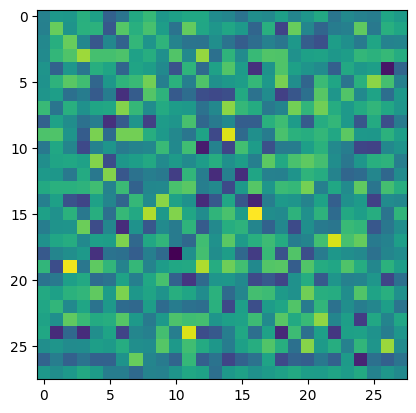

In [28]:
# Test the Generator
noise_vector = 100
z = torch.randn(1, noise_vector).to(device)
G = Generator(noise_vector).to(device)

generated_image = G(z)
print(f"Output image shape: {generated_image.shape}")

image_numpy = generated_image.detach().squeeze().cpu().numpy()
image_numpy = image_numpy*255 #Convert froom [0-1] -> [0-255]
print(f"Output image shape: {image_numpy.shape}")

image_numpy.astype(np.uint8) # Float -> int
plt.imshow(image_numpy)

#Should see a 28x28 image

### 🎯 GAN Loss Functions (Minimax Game)

Minimax Objective:  
$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$

Discriminator Loss:  
$L_D = -\log D(x) - \log(1 - D(G(z)))$ ← Minimize to classify real/fake

Generator Loss (original):  
$L_G = -\log(1 - D(G(z)))$ ← Can saturate if $D(G(z))$ → 0

✅ Alternative (non-saturating):  
$L_G = -\log D(G(z))$ ← Stronger gradients, better training


In [38]:
#Set up before training loop
noise_vector = 100
z = torch.randn(train_loader.batch_size, noise_vector).to(device)
generator = Generator(noise_vector).to(device)
discriminator = Discriminator().to(device)

#Loss function for both discriminator and generator
criterion = nn.BCEWithLogitsLoss()

#Adam optimizer for both
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))




# 4. Training Loop

[Epoch 1] Train D Loss: 1.1723 | G Loss: 0.9413
[Epoch 1] Val   D Loss: 1.1892 | G Loss: 0.8356
[Epoch 5] Train D Loss: 1.2923 | G Loss: 0.8175
[Epoch 5] Val   D Loss: 1.2862 | G Loss: 0.7455
[Epoch 10] Train D Loss: 1.3254 | G Loss: 0.7728
[Epoch 10] Val   D Loss: 1.3249 | G Loss: 0.6555
[Epoch 15] Train D Loss: 1.3427 | G Loss: 0.7563
[Epoch 15] Val   D Loss: 1.3319 | G Loss: 0.7149
[Epoch 20] Train D Loss: 1.3535 | G Loss: 0.7417
[Epoch 20] Val   D Loss: 1.3798 | G Loss: 0.7756
[Epoch 25] Train D Loss: 1.3593 | G Loss: 0.7335
[Epoch 25] Val   D Loss: 1.3855 | G Loss: 0.9156
[Epoch 30] Train D Loss: 1.3647 | G Loss: 0.7251
[Epoch 30] Val   D Loss: 1.3647 | G Loss: 0.7663
[Epoch 35] Train D Loss: 1.3655 | G Loss: 0.7240
[Epoch 35] Val   D Loss: 1.3571 | G Loss: 0.7614
[Epoch 40] Train D Loss: 1.3652 | G Loss: 0.7264
[Epoch 40] Val   D Loss: 1.3659 | G Loss: 0.7507
[Epoch 45] Train D Loss: 1.3586 | G Loss: 0.7306
[Epoch 45] Val   D Loss: 1.3541 | G Loss: 0.7423
[Epoch 50] Train D Loss:

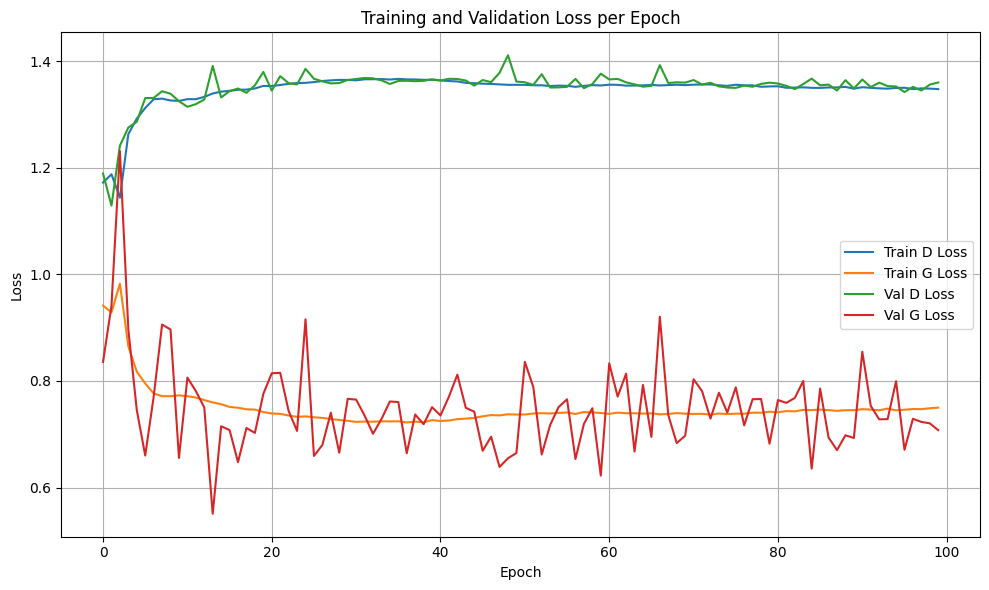

In [40]:
num_epochs = 100

epoch_train_d = []
epoch_train_g = []
epoch_val_d = []
epoch_val_g = []


for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    total_train_d = 0.0
    total_train_g = 0.0
    train_batches = 0

    for data, _ in train_loader: #Labels not used in GANs
        real_images = data.to(device)
        batch_size = real_images.size(0)

        # Discriminator step
        z = torch.randn(batch_size, noise_vector).to(device)
        fake_images = generator(z) G(z)
        pred_real = discriminator(real_images) #D(x)
        pred_fake = discriminator(fake_images.detach()) #D(G(z))

        loss_real = criterion(pred_real, torch.ones_like(pred_real))
        loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
        loss_discriminator = loss_real + loss_fake


        d_optimizer.zero_grad()
        loss_discriminator.backward()
        d_optimizer.step() #Gradient update

        # Generator step
        z = torch.randn(batch_size, noise_vector).to(device)
        fake_images = generator(z)
        pred_fake_for_g = discriminator(fake_images)

        loss_generator = criterion(pred_fake_for_g, torch.ones_like(pred_fake_for_g))

        #Update weights
        g_optimizer.zero_grad()
        loss_generator.backward()
        g_optimizer.step()

        #Sum total losses
        total_train_d +=loss_discriminator.item()
        total_train_g +=loss_generator.item()
        train_batches += 1

    #Average training losses
    avg_train_d = total_train_d / train_batches
    avg_train_g = total_train_g / train_batches

    # === Validation  ===
    generator.eval()
    discriminator.eval()
    total_val_d = 0.0
    total_val_g = 0.0
    val_batches = 0

    with torch.inference_mode():
        for val_data, _in val_loader:
            real_images = val_data.to(device)
            batch_size = real_images.size(0)
            z = torch.randn(batch_size, noise_vector).to(device)
            fake_images = generator(z)

            pred_real = discriminator(real_images)
            pred_fake = discriminator(fake_images)

            loss_real = criterion(pred_real, torch.ones_like(pred_real))
            loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
            val_d_loss = loss_real + loss_fake
            val_g_loss = criterion(pred_fake, torch.ones_like(pred_fake))

            #Sum total losses
            total_val_d += val_d_loss.item()
            total_val_g += val_g_loss.item()
            val_batches += 1

    #Average validation losses
    avg_val_d = total_val_d / val_batches
    avg_val_g = total_val_g / val_batches

    epoch_train_d.append(avg_train_d)
    epoch_train_g.append(avg_train_g)
    epoch_val_d.append(avg_val_d)
    epoch_val_g.append(avg_val_g)
    # === Print every 5 epochs ===
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"[Epoch {epoch+1}] Train D Loss: {avg_train_d:.4f} | G Loss: {avg_train_g:.4f}")
        print(f"[Epoch {epoch+1}] Val   D Loss: {avg_val_d:.4f} | G Loss: {avg_val_g:.4f}")


#Plot graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_d, label="Train D Loss")
plt.plot(epoch_train_g, label="Train G Loss")
plt.plot(epoch_val_d, label="Val D Loss")
plt.plot(epoch_val_g, label="Val G Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📈 GAN Training Loss Summary (Train vs Validation)

The plot above shows the evolution of Generator and Discriminator losses over 100 epochs for both training and validation sets.

#### 🔍 Observations:

- **Discriminator Loss (Train & Val)**:  
  Both losses stabilize around **1.35**, which is expected at equilibrium when the discriminator becomes uncertain (i.e., outputs ≈ 0.5). This suggests a balanced adversarial game.

- **Generator Loss (Train)**:  
  Initially high, then gradually decreases and flattens around **0.75–0.8**, indicating the generator is learning and consistently trying to fool the discriminator.

- **Generator Loss (Val)**:  
  Noisy but remains in a healthy range (**0.6–0.9**), which is typical due to the adversarial dynamics in GAN training. No signs of mode collapse or vanishing gradients.

#### ✅ Overall Assessment:
- The GAN appears to be **training stably** with no major signs of collapse.
- Loss curves are behaving as expected in a balanced GAN setup.
- Visual inspection of generated samples is recommended to further validate quality.



# 5.Test the output

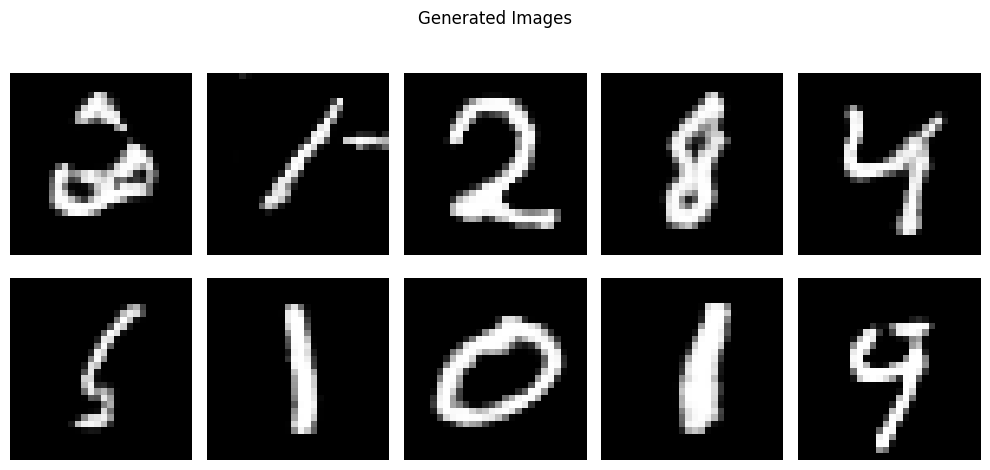

In [62]:
z = torch.randn(train_loader.batch_size, noise_vector).to(device)
generated_images = generator(z).squeeze(dim = 1).detach().cpu().numpy()
generated_images = generated_images*255
generated_images = generated_images.astype(np.uint8)


fig, axs = plt.subplots(2,5, figsize=(10, 5))
fig.suptitle("Generated Images")

for i in range(10):
    row = i// 5
    col = i % 5
    axs[row, col].imshow(generated_images[i], cmap='gray')
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()





### 🎉 Generated Results — Pretty Good for a Small Self implemented GAN!

The grid above shows 10 samples generated by the trained generator.

- Most digits are **recognizable**, with several well-formed examples (like 0, 1, 2, 9), but some do struggle like 5
- Some samples show **minor distortion**, which is expected in early-stage or lightweight GANs.
- These results demonstrate that even a **small convolutional GAN** can learn meaningful digit structure from MNIST.



